Variable支持大部分tensor支持的函数，但不支持部分inplace functions.BP中，需要缓存原来的tensor来计算梯度

In [1]:
import torch as t
from torch.autograd import Variable as V

In [2]:
a = V(t.ones(3,4),requires_grad=True)
a

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)

In [3]:
b = V(t.zeros(3,4))
b

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [5]:
c = a+b
c

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], grad_fn=<AddBackward0>)

In [7]:
d = c.sum()
d

tensor(12., grad_fn=<SumBackward0>)

In [8]:
d.backward() # BP

In [10]:
c.data.sum() #变为tensor

tensor(12.)

In [11]:
c.sum() #还是variable

tensor(12., grad_fn=<SumBackward0>)

In [12]:
a.grad

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [13]:
a.is_leaf,b.is_leaf,c.is_leaf

(True, True, False)

In [14]:
c.grad is None

True

In [15]:
def f(x):
    y = x**2*t.exp(x)
    return y

def gradf(x):
    #手动求导
    dx = 2*x*t.exp(x) + x**2*t.exp(x)
    return dx

In [17]:
x = V(t.randn(3,4),requires_grad=True) #只会需要对x求导
print(x)
y = f(x)
print(y)

tensor([[-0.5964,  1.9731,  0.7437, -0.1293],
        [ 0.6173, -0.2529, -0.9487,  0.7451],
        [-2.0846,  0.5892, -1.3617,  0.8642]], requires_grad=True)
tensor([[1.9590e-01, 2.8003e+01, 1.1634e+00, 1.4696e-02],
        [7.0655e-01, 4.9663e-02, 3.4851e-01, 1.1694e+00],
        [5.4040e-01, 6.2573e-01, 4.7509e-01, 1.7725e+00]],
       grad_fn=<MulBackward0>)


In [18]:
y.backward(t.ones(y.size()))
print(x.grad)
print(gradf(x))

tensor([[-4.6107e-01,  5.6389e+01,  4.2923e+00, -2.1258e-01],
        [ 2.9956e+00, -3.4310e-01, -3.8624e-01,  4.3086e+00],
        [ 2.1938e-02,  2.7498e+00, -2.2272e-01,  5.8744e+00]])
tensor([[-4.6107e-01,  5.6389e+01,  4.2923e+00, -2.1258e-01],
        [ 2.9956e+00, -3.4310e-01, -3.8624e-01,  4.3086e+00],
        [ 2.1938e-02,  2.7498e+00, -2.2272e-01,  5.8744e+00]],
       grad_fn=<AddBackward0>)


In [19]:
x = V(t.ones(1))
b = V(t.rand(1),requires_grad=True)
w = V(t.rand(1),requires_grad=True)
y = w*x
z = y+b

In [23]:
x.requires_grad, b.requires_grad, w.requires_grad, y.requires_grad, z.requires_grad

(False, True, True, True, True)

In [24]:
x.is_leaf, w.is_leaf, b.is_leaf, y.is_leaf, z.is_leaf

(True, True, True, False, False)

In [25]:
#查看该variable的反向传播函数
z.grad_fn

In [26]:
z.grad_fn.next_functions

((<MulBackward0 at 0x11f7d74a8>, 0), (<AccumulateGrad at 0x11f7d70f0>, 0))

In [27]:
z.grad_fn.next_functions[0][0] == y.grad_fn

True

In [28]:
y.grad_fn.next_functions

((<AccumulateGrad at 0x11f7d72e8>, 0), (None, 0))

In [29]:
w.grad_fn, x.grad_fn

(None, None)

In [31]:
y.grad_fn.saved_variables # pytorch0.3中saved_variables 现在是一个c++的对象，无法通过python访问，直接下一步即可

AttributeError: 'MulBackward0' object has no attribute 'saved_variables'

In [32]:
z.backward(retain_graph=True)
w.grad

tensor([1.])

In [33]:
z.backward()
w.grad #梯度累加

tensor([2.])

In [34]:
def abs(x):
    if x.data[0]>0:
        return x
    else:
        return -x

x = V(t.ones(1),requires_grad=True)
y = abs(x)
y.backward()
x.grad

tensor([1.])

In [35]:
x = V(-1*t.ones(1),requires_grad=True)
y = abs(x)
y.backward()
x.grad

tensor([-1.])

In [38]:
def f(x):
    result = 1
    for ii in x:
        if ii.data.item()>0:
            result = ii*result
    return result

x = V(t.arange(-2,4).float(),requires_grad=True)
y = f(x)
y.backward()
x.grad

tensor([0., 0., 0., 6., 3., 2.])

查看非叶子节点的梯度

In [40]:
#autograd.grad (隐式求导)
x = V(t.ones(3),requires_grad=True)
w = V(t.rand(3),requires_grad=True)
y = x*w
z = y.sum()
#z对y的梯度
t.autograd.grad(z, y)

(tensor([1., 1., 1.]),)

In [41]:
#hook是一个函数，输入是梯度，没有返回值
def variable_hook(grad):
    print('y的梯度',grad)
    
x = V(t.ones(3),requires_grad=True)
w = V(t.rand(3),requires_grad=True)
y = x*w
#注册hook
hook_handle = y.register_hook(variable_hook)
z = y.sum()
z.backward()

#除非每次都要用Hook，否则用完后移除
hook_handle.remove()

y的梯度 tensor([1., 1., 1.])


In [42]:
x = V(t.arange(0,3).float(),requires_grad=True)
y = x**2 + x*2
z = y.sum()
z.backward()
x.grad

tensor([2., 4., 6.])

In [44]:
x = V(t.arange(0,3).float(),requires_grad=True)
y = x**2 + x*2
z = y.sum()

y_grad_variables = V(t.Tensor([1,1,1])) #dz/dy
y.backward(y_grad_variables) #从y开始反向传播
x.grad

tensor([2., 4., 6.])

### 自定义autograd

In [46]:
from torch.autograd import Function

class Mul(Function):
    
    @staticmethod    
    def forward(ctx,w,x,b,x_requires_grad=True):
        ctx.x_requires_grad = x_requires_grad
        ctx.save_for_backward(w,x)
        output = w*x+b
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        w,x = ctx.saved_variables
        grad_w = grad_output*x
        if ctx.x_requires_grad==True:
            grad_x = grad_output*w
        else:
            grad_x = None
        grad_b = grad_output*1
        return grad_w,grad_x,grad_b,None

### Variable 实现线性回归

In [49]:
import torch as t
from torch.autograd import Variable as V
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

In [50]:
t.manual_seed(1000)

def get_fake_data(batch_size=8):
    x = t.rand(batch_size,1)*20
    y = x*2 + (1+t.randn(batch_size,1))*3
    return x,y

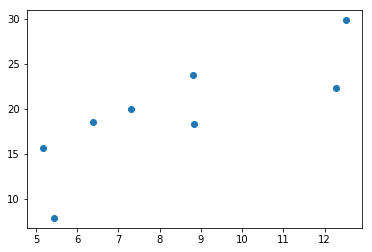

In [51]:
x,y = get_fake_data()
plt.scatter(x.squeeze().numpy(),y.squeeze().numpy())

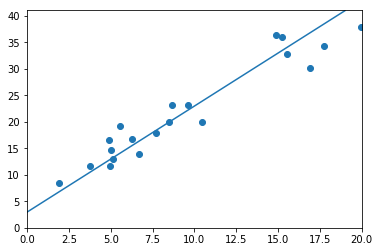

1.7723227739334106 2.844557523727417


In [57]:
w = V(t.rand(1,1),requires_grad=True)
b = V(t.zeros(1,1),requires_grad=True)

lr = 0.001

for ii in range(8000):
    x,y = get_fake_data()
    x,y = V(x),V(y)
    
    #forward:
    y_pred = x.mm(w)+b.expand_as(y)
    loss = 0.5*(y_pred-y)**2
    loss = loss.sum()
    
    #backward
    loss.backward()
    
    #update
    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)
    
    #清零梯度
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if ii%1000==0:
        display.clear_output(wait=True)
        x = t.arange(0,20).view(-1,1)
        y = x.mm(w.data.long()).float()+b.data.expand_as(x)
        plt.plot(x.numpy(),y.numpy()) #predicted
        
        x2,y2 = get_fake_data(batch_size=20)
        plt.scatter(x2.numpy(),y2.numpy())
        
        plt.xlim(0,20)
        plt.ylim(0,41)
        plt.show()
        plt.pause(0.5)
        
print(w.data.squeeze().item(),b.data.squeeze().item())